#Waste Management using CNN

## Downloading Dataset

In [1]:
!pip install kagglehub

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("techsash/waste-classification-data")

print("Path to dataset files:", path)

100%|██████████| 427M/427M [00:04<00:00, 93.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1


## Installing Libraries

In [3]:
# installing ml libraries
!pip install tensorflow
!pip install opencv-python

In [4]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import random

In [5]:
# importing ml libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.utils import plot_model
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import EarlyStopping

# from keras.proprecessing.image import ImageDataGenerator # this is not working
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from glob import glob

In [6]:
# defining traing and test datasets paths
train_path = '/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TRAIN'
test_path = '/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TEST'

## Data Exploration

### Dataframe Preparation

In [7]:
x_data = []
y_data = []

widths = []
heights = []

for category in glob(train_path + '/*'):
    for file in tqdm(glob(category + '/*')):
        img_arr = cv2.imread(file)
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        h, w = img_arr.shape[:2]
        widths.append(w)
        heights.append(h)
        x_data.append(img_arr)
        y_data.append(category.split('/')[-1])

data = pd.DataFrame({'image': x_data, 'label': y_data})

100%|██████████| 9999/9999 [00:10<00:00, 987.52it/s]


In [8]:
data.shape

(22564, 2)

### Random images visualization

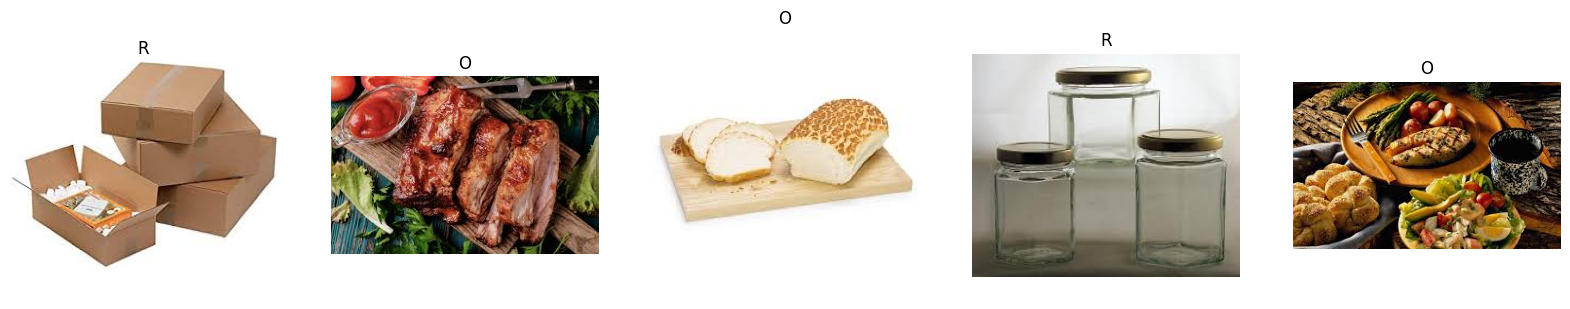

In [9]:
indices = random.sample(range(data.shape[0]), 5)

plt.figure(figsize=(20, 4 * 5))  # Adjust figure size as needed
for i, index in enumerate(indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_data[index])
    plt.title(y_data[index])
    plt.axis('off')
plt.show()

### Class Distribution

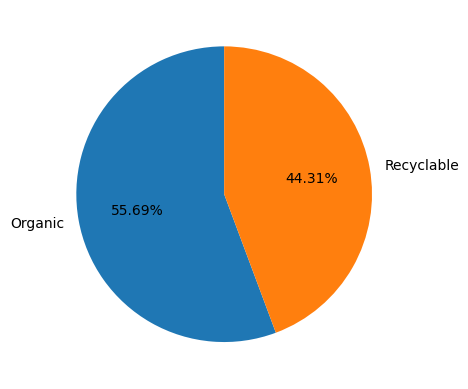

In [10]:
plt.pie(data['label'].value_counts(), labels=["Organic", "Recyclable"], autopct='%1.2f%%', startangle=90)
plt.show()

### Analysing Image sizes

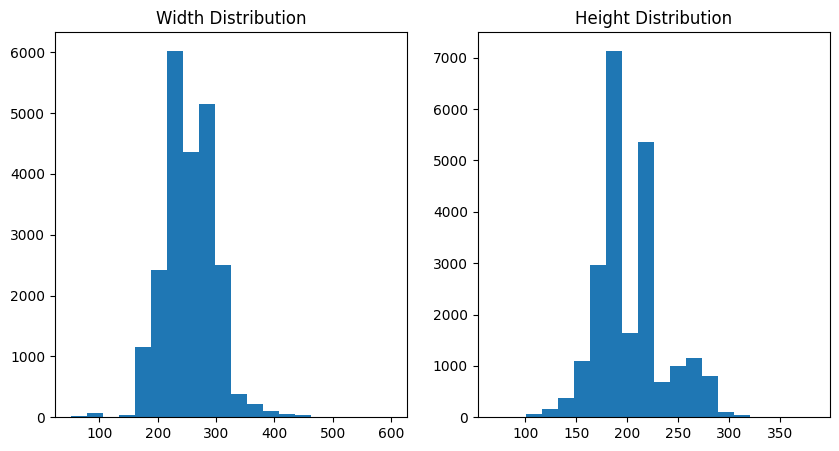

Mean Width: 252.31687644034744, Mean Height: 203.74711930508775


In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20)
plt.title('Width Distribution')
plt.subplot(1, 2, 2)
plt.hist(heights, bins=20)
plt.title('Height Distribution')
plt.show()

print(f"Mean Width: {np.mean(widths)}, Mean Height: {np.mean(heights)}")

## Data Preprocessing

### Data Augmentation and Resizing

In [12]:
# dimensions for resizing
img_width = 224
img_height = 224

# batch size for generating augmented data
batch_size = 64

In [13]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [38]:
train_data_generator = data_generator.flow_from_directory(
    train_path,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = 'binary',
    subset = 'training',
)

validation_data_generator = data_generator.flow_from_directory(
    train_path,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = 'binary',
    subset = 'validation',
)

test_data_generator = ImageDataGenerator(rescale=1./255)

test_generator = test_data_generator.flow_from_directory(
    test_path,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = 'binary',
)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


## Model Building

In [23]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,261,185 (84.92 MB)

 Trainable params: 22,261,185 (84.92 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [24]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
# Fit the model
hist = model.fit(
    train_data_generator,
    epochs=5,  # Increased epochs for training
    validation_data=validation_data_generator,
)

Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.6913 - loss: 0.7934 - val_accuracy: 0.8145 - val_loss: 0.4161
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 32s 286ms/step - accuracy: 0.8096 - loss: 0.4418 - val_accuracy: 0.8234 - val_loss: 0.3783
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - accuracy: 0.8279 - loss: 0.4084 - val_accuracy: 0.8491 - val_loss: 0.3476
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 268ms/step - accuracy: 0.8572 - loss: 0.3549 - val_accuracy: 0.8595 - val_loss: 0.3139
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 259ms/step - accuracy: 0.8619 - loss: 0.3338 - val_accuracy: 0.9009 - val_loss: 0.2489


## Model Evaluation

### Model Accuracy and Loss Curves

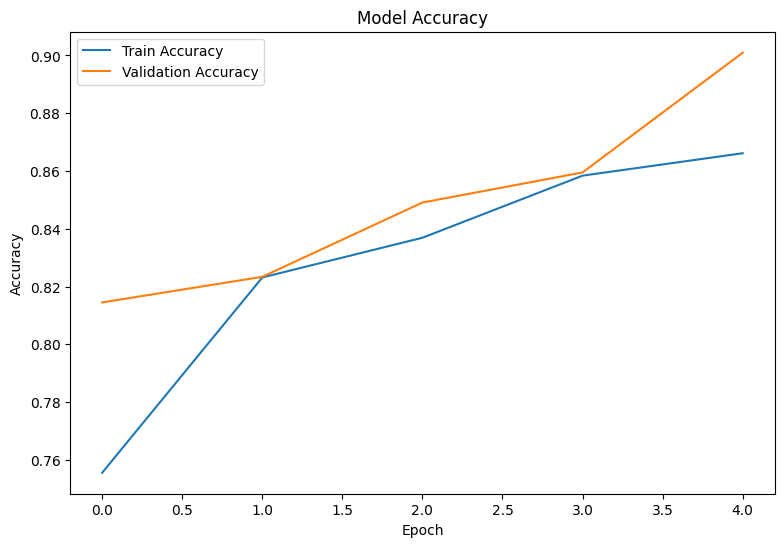

In [35]:
# Plot accuracy and loss curves
plt.figure(figsize=(20, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

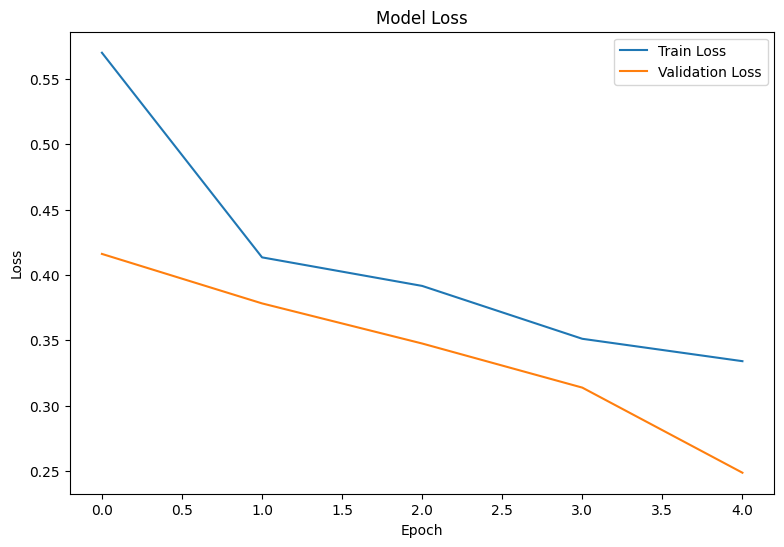

In [36]:
# Loss Plot
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

### Confusion Matrix and Classification Report

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step


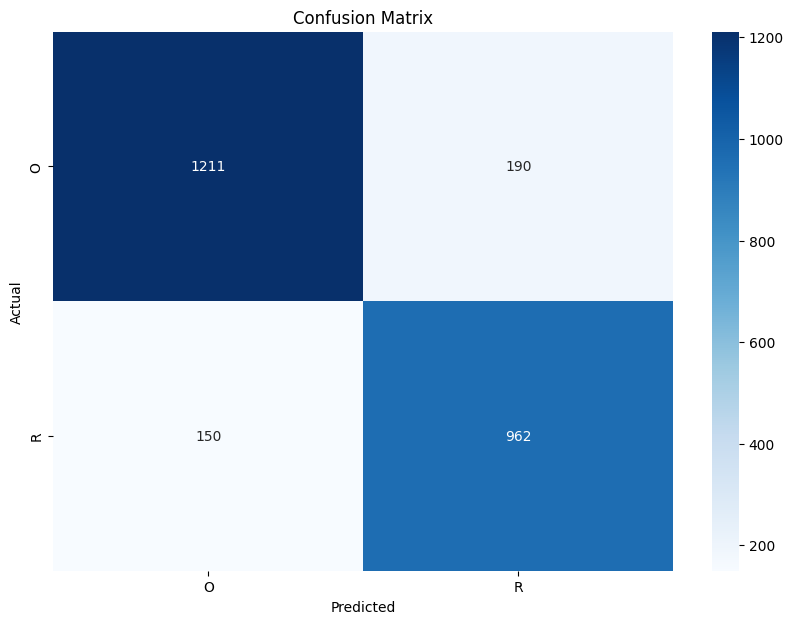

              precision    recall  f1-score   support

           O       0.89      0.86      0.88      1401
           R       0.84      0.87      0.85      1112

    accuracy                           0.86      2513
   macro avg       0.86      0.86      0.86      2513
weighted avg       0.87      0.86      0.86      2513



In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on the test set
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')

# Get true classes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


### Receiver Operating Characteristic

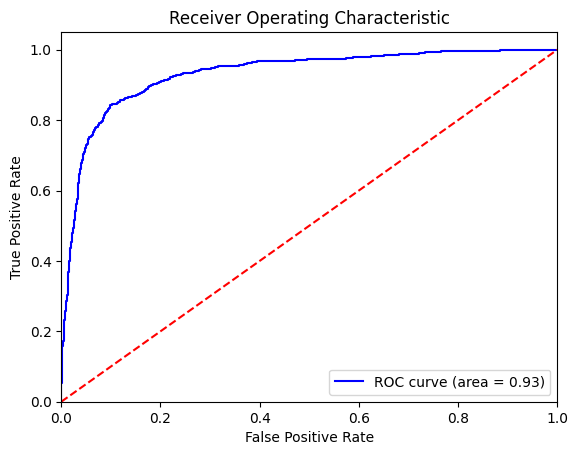

In [30]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, _ = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


### Misclassified Images

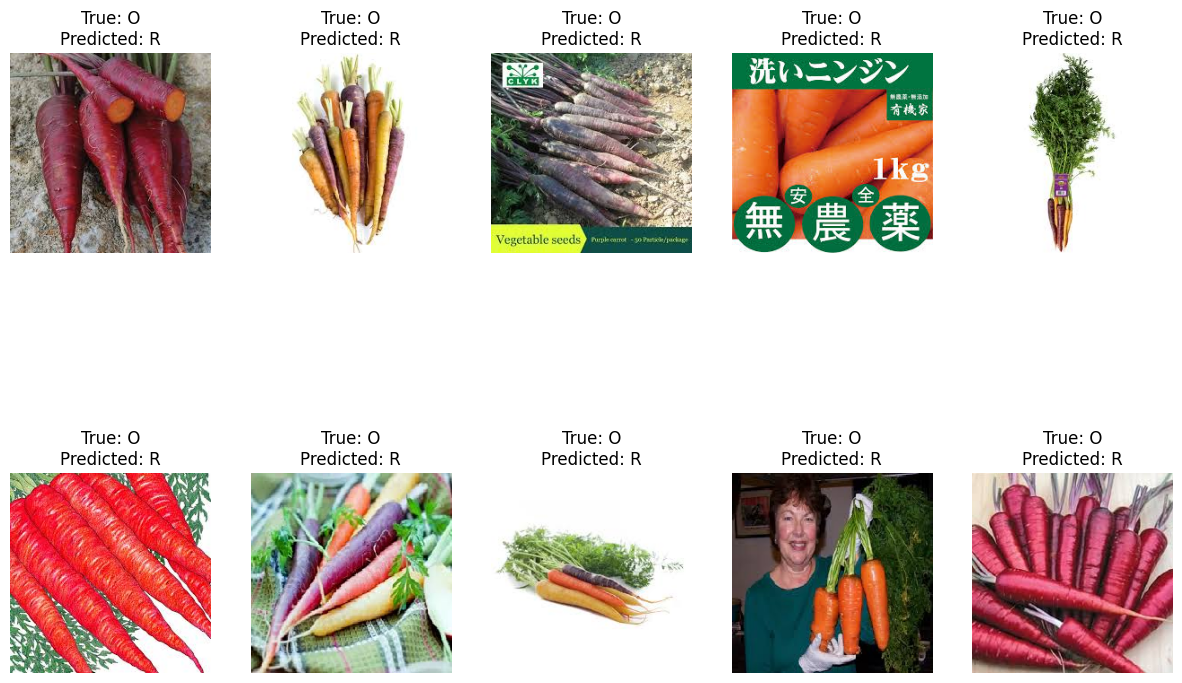

In [31]:
# Analyze misclassifications
misclassified_indices = np.where(predicted_classes.flatten() != true_classes)[0]

plt.figure(figsize=(15, 10))
for i, index in enumerate(misclassified_indices[:10]):  # Display first 10 misclassifications
    plt.subplot(2, 5, i+1)
    # Access the image from the test generator using the batch index and image index within the batch
    batch_index = index // test_generator.batch_size
    image_index = index % test_generator.batch_size
    image = test_generator[batch_index][0][image_index]
    plt.imshow(image.astype('float32'))
    plt.title(f'True: {class_labels[true_classes[index]]}\nPredicted: {class_labels[predicted_classes[index][0]]}')
    plt.axis('off')
plt.show()


## Model Evaluation on unseen data

In [37]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.8714 - loss: 0.3046
Test Loss: 0.2181943106651306, Test Accuracy: 0.9247035360336304


## Saving Model

In [ ]:
# save the model if performance is good
from tensorflow.keras.models import load_model

model.save('waste_classification_model.h5')

## Model Deployment

**Link:** https://waste-classifier-busdsh36gmgochhha3ovz6.streamlit.app/